# Ajuste de las curvas obtenidas en el transitorio del circuito RC

En este tutorial analizo los datos adquiridos de un circuito RC transitorio.

El circuito tiene las siguientes características:

```
 _____ -V0 (PULSE)+ _____ R _____ C ____   
|                     |       |         |  
GND                  Vin     VC         GND
```

Parámetros:
- C = 1 $\mu F$
- R = 10 $k\Omega$
- Tiempo característico $\tau = RC \approx 0.01$ sec
- $V_0$ tren de pulsos cuadrados, tension en alto $5V$. Tiempo de alto y tiempo de bajo $10\tau$

Empezamos importando las librerías necesarias:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

Cargamos los datos, y hacemos una exploración inicial:

In [3]:
df = pd.read_csv("datos/data_RC.csv")

df.head()

,time,Vin,VC,I
0,0.000000e+00,0.000774,-0.002487,0.000001
1,1.000000e-09,4.997539,0.012046,0.000503
2,7.590087e-05,4.993808,0.042974,0.000496
3,1.518007e-04,4.999363,0.058885,0.000494
4,2.277006e-04,4.996502,0.122209,0.000489


<Axes: xlabel='time'>

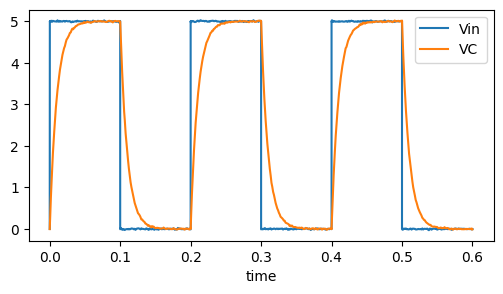

In [ ]:
df.plot(x="time", y=["Vin", "VC"], kind="line", figsize=(6, 3))     # gráfico exploratorio

### RC Carga

Vamos a utilizar uno de los pulsos para ajustar la corriente y la tensión en el capacitor en el proceso de carga (pulso en alto).

Supongamos que queremos ajustar el segundo pulso, el que va desde $t=0.2$ a $t=0.3$. En primer lugar tenemos que tomar los datos que solo estan en esa parte de la curva, hacemos un filtrado:

In [5]:
# Defino un tiempo inicial y uno final
t1 = 0.2                
t2 = 0.3

# filtro los datos
df_carga = df[ (df["time"]>t1) & (df["time"]<t2) ]

El dataframe *df_carga* contiene solo la parte de la curva que nos interesa. Para checkear que tomamos los datos correctamente, utilizamos la rutina plot de pandas para hacer una inspección visual rápida:

<Axes: xlabel='time'>

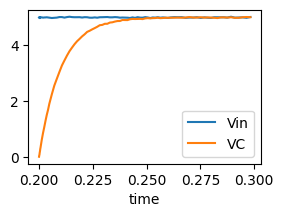

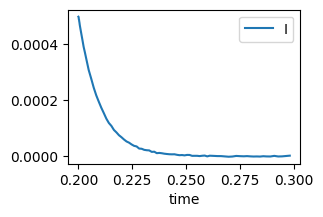

In [6]:
df_carga.plot(x="time", y=["Vin", "VC"], kind="line", figsize=(3, 2))

df_carga.plot(x="time", y="I", kind="line", figsize=(3, 2))

Como vemos el filtro funcionó correctamente.

Ahora, note que en el eje x el *tiempo cero* quedo dezplazado. Transformo los datos para que vayan desde $t=0$ a $t=0.1$, esto es un paso previo necesario para luego ejecutar correctamente el ajuste no lineal:

In [7]:
t0 = df_carga["time"].iloc[0]                   # toma el primer dato
t  = df_carga["time"].to_numpy()- t0            # se lo resta a todo el array

VC = df_carga["VC"].to_numpy()   

Note que al mismo tiempo ya pasamos los datos a *numpy array* para mayor comodidad.

Con esto ya podemos hacer el ajuste, primero proponemos el modelo y las semillas (valores aproximados de los parámetros que ayudan al algoritmo a converger más rápido):

In [8]:
def modelo_tension(u, V0, tau):                         # Ec para la tensión VC en el la carga
    z= V0*(1 - np.exp(-u/tau))
    return z

V0_ini  = 1
tau_ini = 1e-3

Ahora ajustamos con *curve fit* para obtener los parámetros:

In [ ]:
popt, pcov = curve_fit(modelo_tension, t, VC, p0=[ V0_ini, tau_ini ] )      

V0, tau = popt

# Errores 
error_V0, error_tau = np.sqrt(np.diag(pcov))

print ("Parámetros obtenidos del ajuste:")
print(f"V_0 = ({V0:.4f} ± {error_V0:.4f})")
print(f"tau = ({tau:.6f} ± {error_tau:.6f})")

Parámetros obtenidos del ajuste:
V_0 = (5.0008 ± 0.0014)
tau = (0.010022 ± 0.000014)


Graficamos datos + ajuste:

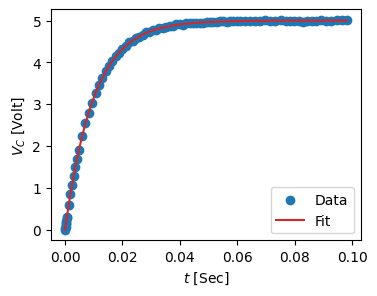

In [10]:
fig,ax = plt.subplots(figsize=(4,3))

ax.scatter( t, VC ,label='Data')                                    # datos

ax.plot( t, modelo_tension(t, V0, tau), c='C3', label='Fit' )       # modelo con parametros del ajuste

ax.set_xlabel("$t$ [Sec]")
ax.set_ylabel("$V_C$ [Volt]")

plt.legend(loc=4)
plt.show()




Ahora hacemos lo mismo pero para la corriente:

Parámetros obtenidos del ajuste:
I_0 = (0.000500456 ± 0.000000361)
tau = (0.009984803 ± 0.000017085)


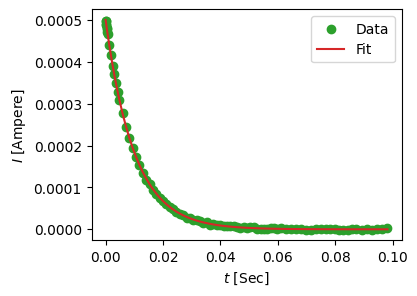

In [15]:
# Tomo data
t0 = df_carga["time"].iloc[0]
t  = df_carga["time"].to_numpy()- t0

I = df_carga["I"].to_numpy()    


# Ec para la tensión VC en el la carga
def modelo_corriente(u, I0, tau):                         
    z= I0*np.exp(-u/tau)
    return z

# semillas
I0_ini  = 0.0001            
tau_ini = 1e-3

# ajuste
popt, pcov = curve_fit(modelo_corriente, t, I, p0=[ I0_ini,tau_ini ] )      

# param del ajuste
I0, tau = popt

# Errores
error_I0, error_tau = np.sqrt(np.diag(pcov))

print ("Parámetros obtenidos del ajuste:")
print(f"I_0 = ({I0:.9f} ± {error_I0:.9f})")
print(f"tau = ({tau:.9f} ± {error_tau:.9f})")


# Gráfico
fig,ax = plt.subplots(figsize=(4,3))

ax.scatter( t, I ,label='Data', c='C2')

ax.plot( t, modelo_corriente(t, I0, tau), c='C3', label='Fit' )

ax.set_xlabel("$t$ [Sec]")
ax.set_ylabel("$I$ [Ampere]")
plt.legend(loc=1)
plt.show()
